In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import SphericalVoronoi
from src import *

In [2]:
def annealing(func, X0, neighbor_func, temperature_schedule, max_iter, tol=1e-8):
    current_solution = X0
    current_objective = func(current_solution)
    
    best_solution = current_solution
    best_objective = current_objective
    
    for t in range(max_iter):
        temperature = temperature_schedule(t)

        neighbor = neighbor_func(current_solution)
        neighbor_objective = func(neighbor)
        
        delta = neighbor_objective - current_objective
        acceptance_probability = np.exp(-delta / temperature) if delta > 0 else 1.0
        
        if np.random.rand() < acceptance_probability:
            current_solution = neighbor
            current_objective = neighbor_objective
        
        if current_objective < best_objective:
            best_solution = current_solution
            best_objective = current_objective
            if current_objective < tol:
                break

        print(f"temp: {temperature:.4f}, \tcur_obj: {current_objective}, \tbest_obj: {best_objective}")
    
    return best_solution, best_objective

In [3]:
def change_random_row(x):
    index = np.random.randint(len(x))
    r = 2 + np.random.randn() / 2
    delta = np.random.randn(len(x[index]))
    delta = delta / np.linalg.norm(delta) * r

    new_x0 = x.copy()
    new_x0[index] = new_x0[index] + delta

    return renorm(new_x0)

In [4]:
def neighbor(x, gd_params=(300, 1e-6, 0.01, True)):
    new_x0 = change_random_row(x)
    return accelerated_gradient(func, grad, new_x0, *gd_params)

In [5]:
def neighbor_kdt(x, params=(10, 30, 500, 1e-6, 0.01, True)):
    new_x0 = change_random_row(x)
    return accelerated_gradient_kdt(func, new_x0, *params)

In [6]:
def temperature(iteration, max_iter, t_init, t_final):
    return t_init - (t_init - t_final) * iteration / max_iter

In [7]:
def k_opt_step(func, x, k, params, tol=1e-6, silent=False):
    # also returns if the search was successful
    
    current_obj = func(x)

    for i in range(len(x)**k):
        candidate = x.copy()
        for j in range(k):
            candidate = change_random_row(candidate)
        # candidate = accelerated_gradient(func, grad, candidate, *gd_params)
        candidate = accelerated_gradient_kdt(func, candidate, *params)
        if func(candidate) < current_obj - tol:
            return candidate, True

        if not silent and i > 0:
            if i % 100 == 0:
                print(f"i = {i} \tout of {len(x)**k}")

    return x, False

In [8]:
def multiopt(func, x0, params, tol=1e-6):
    x = x0.copy()
    cur_obj = func(x)

    k = 1
    
    while cur_obj > tol:
        if func(x) < tol:
            break
        print(f"k: {k}, \tcur_obj: {func(x):.8f}")
        
        x, succ = k_opt_step(func, x, k, params)
        if not succ:
            k += 1
        else:
            k = 1

    return x

In [9]:
n = 11
N = 400
X0 = renorm(np.random.randn(N,n))

sol = multiopt(func, X0, (10, 30, 500, 1e-6, 0.01, True))
func(sol), sol

In [10]:
max_iter = 100
t_max = 0.1
t_min = 0

sol, obj = annealing(func, X0, neighbor, lambda t: temperature(t, max_iter, t_max, t_min), max_iter)
func(sol), sol

In [11]:
n = 2
N = 6
X0 = renorm(np.random.randn(N,n))

In [12]:
sv = SphericalVoronoi(X0, 1, np.zeros_like(X0[0]))

(-1.1, 1.1)

<Figure size 700x700 with 0 Axes>

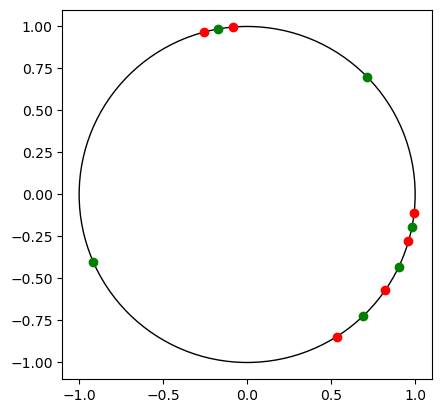

In [13]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_patch(circle)
plt.scatter(X0[:,0], X0[:,1], c='r')
plt.scatter(sv.vertices[:,0], sv.vertices[:,1], c='g')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [14]:
def potentials(X):
    # returns a vector of potentials for each point in X
    squared_norms = np.sum(X**2, axis=1)
    squared_dists = squared_norms[:, np.newaxis] + squared_norms - 2 * X @ X.T
    squared_dists = np.minimum(squared_dists, 1)
    potentials_pairwise = (1 - squared_dists)**2
    return np.sum(potentials_pairwise, axis=1) - np.ones(len(X))

In [167]:
def potentials_in_points(X, points, tree):
    # returns a vector of potentials for each point in points
    dists, inds = tree.query(points, k=len(X), distance_upper_bound=1)
    dists = np.minimum(dists, 1)
    potentials_pairwise = (1 - dists**2)**2
    return np.sum(potentials_pairwise, axis=1)

In [183]:
def smart_k_opt(func, x, k, num_tries, t_max, params, tol=1e-6, silent=False):
    # also returns if the search was successful
    
    current_obj = func(x)
    sv = SphericalVoronoi(x, 1, np.zeros_like(x[0]))
    sv_vertices = sv.vertices
    
    # potentials_x = potentials(x)
    # potentials_x = np.maximum(0, potentials(x))
    # potentials_x = potentials_x / np.max(potentials_x)

    tree = KDTree(x)

    closest_dists, _ = tree.query(x, k=1)
    potentials_x = np.maximum(0, 1 - closest_dists)
    potentials_x = potentials_x / np.max(potentials_x)
    
    potentials_vertices = np.maximum(0, potentials_in_points(x, sv_vertices, tree))
    potentials_vertices = potentials_vertices / np.max(potentials_vertices)

    for i in range(num_tries):
        probas_x = np.exp(potentials_x * t_max * (num_tries - i) / num_tries)
        probas_x = probas_x / np.sum(probas_x)
        probas_vertices = np.exp(- potentials_vertices * t_max * (num_tries - i) / num_tries)
        probas_vertices = probas_vertices / np.sum(probas_vertices)
        
        candidate = x.copy()
        index_x = np.random.choice(np.arange(len(x)), k, p=probas_x, replace=False)
        np.random.shuffle(index_x)
        index_vertex = np.random.choice(np.arange(len(sv_vertices)), k, p=probas_vertices, replace=False)
        np.random.shuffle(index_vertex)
        candidate[index_x] = sv_vertices[index_vertex].copy()
        candidate = accelerated_gradient_kdt(func, candidate, *params)
        if func(candidate) < current_obj - tol:
            print(f"success at iteration {i}")
            return candidate, True

        if not silent and i > 0:
            if i % 100 == 0:
                print(f"i = {i} \tout of {num_tries}")

    print(f"no success after {num_tries} iterations")
    return x, False

In [184]:
def smart_multiopt(func, x0, ceiling_iters, t_max, params, tol=1e-6):
    x = x0.copy()
    cur_obj = func(x)

    k = 1
    
    while cur_obj > tol:
        if func(x) < tol:
            break
        print(f"k: {k}, \tcur_obj: {func(x):.8f}")

        
        x, succ = smart_k_opt(func, x, k, np.minimum(ceiling_iters, len(x0)**np.minimum(k, 2)), t_max, params)
        if not succ:
            k += 1
        else:
            k = 1

    return x

In [204]:
n = 5
N = 40
X0 = renorm(np.random.randn(N,n))

In [205]:
%%time
sv = SphericalVoronoi(X0, 1, np.zeros_like(X0[0]))
len(sv.vertices)

CPU times: user 10.5 ms, sys: 2 ms, total: 12.5 ms
Wall time: 10 ms


558

In [206]:
sol = smart_multiopt(func, X0, 500, 3, (10, 20, 500, 1e-6, 0.01, True)) 
func(sol), sol

k: 1, 	cur_obj: 24.22542272
success at iteration 0
k: 1, 	cur_obj: 0.09081265
success at iteration 1
k: 1, 	cur_obj: 0.05480840
success at iteration 4
k: 1, 	cur_obj: 0.05479258
no success after 40 iterations
k: 2, 	cur_obj: 0.05479258
success at iteration 12
k: 1, 	cur_obj: 0.03164674
success at iteration 2
k: 1, 	cur_obj: 0.02980448
success at iteration 7
k: 1, 	cur_obj: 0.02971770
success at iteration 2
k: 1, 	cur_obj: 0.02960328
success at iteration 16
k: 1, 	cur_obj: 0.02958912
success at iteration 4
k: 1, 	cur_obj: 0.02957054
no success after 40 iterations
k: 2, 	cur_obj: 0.02957054
success at iteration 91
k: 1, 	cur_obj: 0.02956854
no success after 40 iterations
k: 2, 	cur_obj: 0.02956854
i = 100 	out of 500
i = 200 	out of 500
i = 300 	out of 500


KeyboardInterrupt: 

### spherical Voronoi is too heavy in dimension >=10